## Integrated Historical CO$_{2}$ Flux

What is the spread on integrated global CO$_{2}$ and Southern Ocean CO$_{2}$ flux? 

1. CMIP6 multi-model spread (fully coupled ESMs)
2. OMIP multi-model spread (reconstructions)

This is motivated by Nikki's figure for the IPCC:

![](https://i.ibb.co/LppydBD/Screen-Shot-2019-07-31-at-10-02-22-AM.png)

In [ ]:
%matplotlib inline
import numpy as np
import xarray as xr
import esm_analysis as ea
import glob
import proplot as plot
import matplotlib.pyplot as plt
import yaml
from scipy.io import loadmat
from matplotlib.patches import Rectangle

## CMIP6 multi-model mean

In [ ]:
# open YAML file with available models
with open('fgco2_cmip6.yaml') as f:
    fgco2_in = yaml.safe_load(f)

**Just member 1 of all of them**

In [ ]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [ ]:
# Since we're dealing with native grids and remapped grids, will do this one-by-one
# to start.
basepath = '/global/cscratch1/sd/cmip6/CMIP6/CMIP'
for inst in fgco2_in:
    for model in fgco2_in[inst]:
        # Number of their forcing type [1, 2]
        # NOTE: convert forcing to list
        print(f'Institute: {inst}; Model: {model}...')
        model_attrs = fgco2_in[inst][model]
        fNum = model_attrs['forcing']
        grid = model_attrs['grid']
        version = model_attrs['version']
        filepath = f'{basepath}/{inst}/{model}/historical/r1i1p1f{fNum}/Omon/fgco2/{grid}/{version}/'
        # Load in FGCO2
        ds = xr.open_mfdataset(filepath + '*.nc')['fgco2']
        ds = ds.chunk({'time': 1})
        # Load in cell area
        areacello = xr.open_dataset(f'/global/cscratch1/sd/bradyrx/areacello/areacello_{model}.nc')['areacello']
        # combine
        ds = ds.reset_coords(drop=True)
        # units are kg / m2 / s
        lat = model_attrs['lat']
        lon = model_attrs['lon']
        print('Integrating...')
        fgco2_int = (ds * areacello).sum([lat, lon])
        fgco2_int = ea.temporal.to_annual(fgco2_int, calendar=model_attrs['calendar']).rename('fgco2').load()
        FACTOR = eval(model_attrs['conversion'])
        fgco2_int *= FACTOR
        fgco2_int.attrs['description'] = 'Global integral of air-sea CO2 flux; annual averages.'
        fgco2_int.attrs['units'] = 'Pg C / yr'
        fgco2_int.attrs['member'] = '1'
        fgco2_int.attrs['forcing'] = fNum
        fgco2_int.attrs['model'] = model
        print('Saving...')
        fgco2_int.to_dataset().to_netcdf(f'/global/homes/b/bradyrx/CMIP6_hackathon/processed/{model}_global_int.nc')

### OMIP


CNRM

In [ ]:
ds = xr.open_dataset('/global/homes/b/bradyrx/scratch/OMIP/fgco2_Omon_CNRM-ESM2-1_omip1_r1i1p1f2_gn_195001-200912.nc')['fgco2']
areacello = xr.open_dataset('/global/homes/b/bradyrx/scratch/areacello/areacello_CNRM-ESM2-1.nc')['areacello']
fgco2_int = (ds * areacello).sum(['y', 'x'])
fgco2_int = ea.temporal.to_annual(fgco2_int, calendar='noleap').rename('fgco2')
FACTOR = -1*60*60*24*365.25/1e12
fgco2_int *= FACTOR
fgco2_int.attrs['description'] = 'Global integral of air-sea CO2 flux; annual averages'
fgco2_int.attrs['units'] = 'Pg C / yr'

IPSL

In [ ]:
ds = xr.open_mfdataset('/global/homes/b/bradyrx/scratch/OMIP/*IPSL*.nc', concat_dim='member')['fgco2']
areacello = xr.open_dataset('/global/homes/b/bradyrx/scratch/areacello/areacello_IPSL-CM6A-LR.nc')['areacello']
ds = ds.reset_coords(drop=True)
ds = ds.sel(time=slice('1950', '2010'))
ds = (ds*areacello).sum(['x','y'])
ds = ea.temporal.to_annual(ds, calendar='noleap').rename('fgco2')
ds *= -1*60*60*24*365.25/1e12
ds = ds.load()
# Second member seems to be fixed carbon.
# ds.isel(member=0).to_dataset().to_netcdf('/global/homes/b/bradyrx/CMIP6_hackathon/processed/OMIP/IPSL-CM6A-LR_195001-200912.nc')

# Reproduce Nikki IPCC Figure

GCB runs from 1959 - 2017

In [2]:
# for preindustrial outgassing in PgC/yr
RIVER_CORRECTION = 0.45 

# open YAML file with observational time ranges
with open('ipcc.yaml') as f:
    ipcc = yaml.safe_load(f)

In [3]:
# Reconstructions
GCB = ['cesm', 'cnrm', 'ipsl', 'mit', 'mpi', 'noresm', 'planktom']
basepath = '/global/homes/b/bradyrx/scratch/nikki_IPCC/GCB/mat'
GCB_filepaths = [f'{basepath}/{i}.mat' for i in GCB]

# Observational-Estimates
SOCOM = ['somffn_global', 'jena_global', 'jma_global',
         'csir_global', 'niesnn_global', 'lsce_global']
SOCOM_filepaths = [f'{basepath}/{i}.mat' for i in SOCOM]

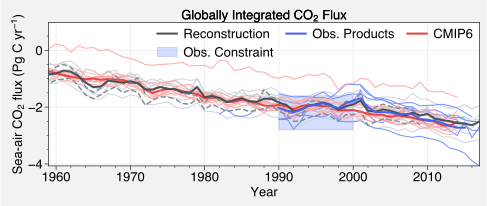

In [12]:
plot.rc.small = 13
plot.rc.large = 13
plot.rc['legend.frameon'] = False

f, ax = plot.subplots(axwidth=6, aspect=3)

# GCB Results
mmm = 0
for i, run in enumerate(GCB_filepaths):
    # GCB with negative being uptake
    ds = (xr.DataArray(loadmat(GCB_filepaths[i])[GCB[i]].squeeze(),
                      dims='time') * -1)
    ds['time'] = np.arange(1959, 2018)
    ds.plot(color='gray4', ax=ax, linewidth=1)
    # Finding multi-model mean
    mmm += ds
(mmm / 7).plot(color='gray7', ax=ax, zorder=5, linewidth=2,
               label='Reconstruction')

# SOCOM Results
basepath = '/global/homes/b/bradyrx/scratch/nikki_IPCC/SOCOM/mat'
mmm = 0
for i, obs in enumerate(ipcc['observations']):
    filename = f'{basepath}/{obs}_global.mat'
    ds = xr.DataArray(loadmat(filename)[f'{obs}_global'].squeeze(),
                      dims='time') - RIVER_CORRECTION
    time_range = ipcc['observations'][obs]['time_range']
    ds['time'] = np.arange(time_range[0], time_range[-1] + 1)
    ds.plot(color='indigo4', ax=ax, linewidth=1)
    
    # Finding multi-model mean
    if obs != 'lsce':
        ds = ds.sel(time=slice(1990, 2015))
        mmm += ds
(mmm / 5).plot(color='indigo7', ax=ax, zorder=5, linewidth=2,
               label='Obs. Products')

# CMIP6 : 1 realization (first one)
ds = xr.open_mfdataset('../processed/first_member/*.nc', concat_dim='member')
ds.fgco2.plot(hue='member', ax=ax, color='red3', add_legend=False,
              linewidth=1)

# Exclude CNRM (outlier)
ds.isel(member=[0,1,2,4,5,6,7,8]).mean('member').fgco2.plot(color='red7', linewidth=2,
                                                            label='CMIP6')

ax.add_patch(Rectangle((1990, -2.8), 10, 1.2, color='indigo4', alpha=0.3, 
                       label='Obs. Constraint'))

# OMIP for CMIP6
omip = xr.open_mfdataset('/global/homes/b/bradyrx/CMIP6_hackathon/processed/OMIP/*.nc',
                         concat_dim='member')
omip.fgco2.plot(hue='member', color='gray6', linestyle='--', linewidth=1.5, add_legend=False)

# Aesthetics
ax.format(xlim=[1959, 2017], ylabel='Sea-air CO$_{2}$ flux (Pg C yr$^{-1}$)',
          xlabel='Year', title='Globally Integrated CO$_{2}$ Flux')
plt.legend()

#f.save('../figures/IPCC_single_member_global_withOMIP.png', dpi=300)